In [57]:
p * np.pi * 0

0.0

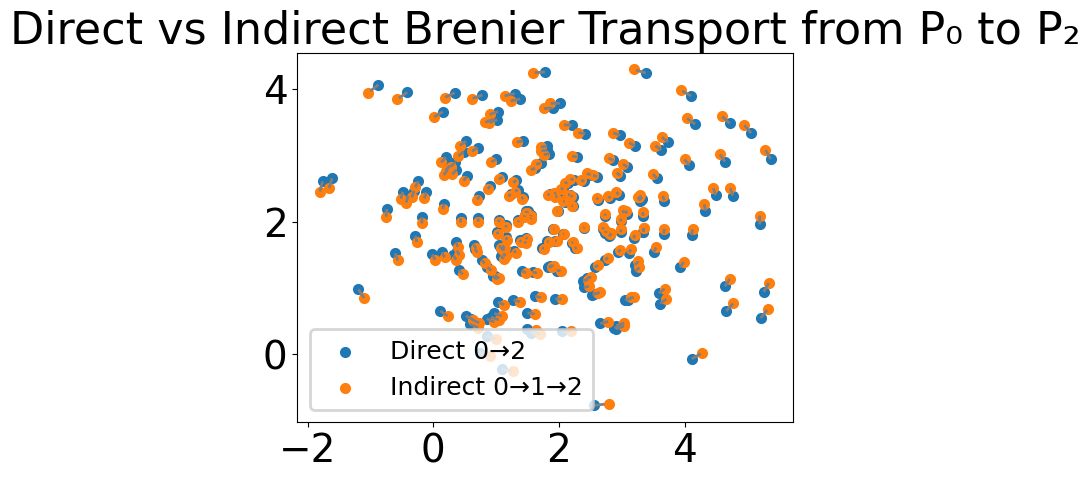

In [65]:
    import numpy as np
    import scipy.linalg
    import matplotlib.pyplot as plt
    
    # Fix random seed for reproducibility
    np.random.seed(0)

    def r(theta):
        return np.array([[np.cos(theta), -np.sin(theta)],
                         [np.sin(theta), np.cos(theta)]])
    p = 0.25
    Lambda = np.diag([1,2])
    
    # 1) Define three 2D Gaussians (means and covariances)
    m0 = np.array([0.0, 0.0])    
    m1 = np.array([1.0, 1.0])
    m2 = np.array([2.0, 2.0])

    S0 = r(p * np.pi * 0) @ Lambda @ r(p * np.pi * 0).T
    S1 = r(p * np.pi * 1) @ Lambda @ r(p * np.pi * 1).T
    S2 = r(p * np.pi * 2) @ Lambda @ r(p * np.pi * 2).T
   # S0 = np.array([[10.0, 0.0],[0.0, 1.0]])
   # S1 = np.array([[1, -0.9], [-0.9, 1.0]])
   # S2 = np.array([[0.5, 0.0],[0.0, 5]])
    L0 = np.linalg.cholesky(S0)
    L1 = np.linalg.cholesky(S1)
    L2 = np.linalg.cholesky(S2)

    # Draw samples
    N = 200
    xi0 = np.random.normal(size = (N,2))
    X0 = m0 + xi0 @ L0.T
    X1 = m1 + xi0 @ L1.T
    X2 = m2 + xi0 @ L2.T
    
    # 2) Compute Brenier-map matrices
    def compute_A(S, S_prime):
        sqrtS     = scipy.linalg.sqrtm(S)
        inv_sqrtS = scipy.linalg.inv(sqrtS)
        M         = sqrtS @ S_prime @ sqrtS
        A         = inv_sqrtS @ scipy.linalg.sqrtm(M) @ inv_sqrtS
        return A.real  # Drop any numerical imaginary parts
    
    A01 = compute_A(S0, S1)
    A02 = compute_A(S0, S2)
    A12 = compute_A(S1, S2)
    
    # Affine Brenier transform
    def T(x, A, m, m_prime):
        return (m_prime + (A @ (x - m).T).T)
    
    # Transform samples from P0
    X02_direct   = T(X0, A02, m0, m2)
    X01          = T(X0, A01, m0, m1)
    X02_indirect = T(X01, A12, m1, m2)
    
    # 3) Plot direct vs indirect transports and draw lines
    fig, ax = plt.subplots()
    ax.scatter(X02_direct[:, 0], X02_direct[:, 1], label='Direct 0→2')
    ax.scatter(X02_indirect[:, 0], X02_indirect[:, 1], label='Indirect 0→1→2')
    
    for i in range(N):
        ax.plot([X02_direct[i, 0], X02_indirect[i, 0]],
                [X02_direct[i, 1], X02_indirect[i, 1]], color = "grey", ls = "--")
    
    ax.set_title('Direct vs Indirect Brenier Transport from P₀ to P₂')
    ax.legend()
    plt.show()


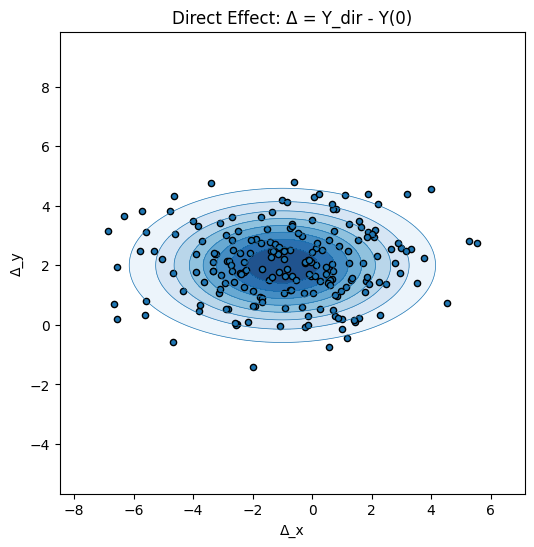

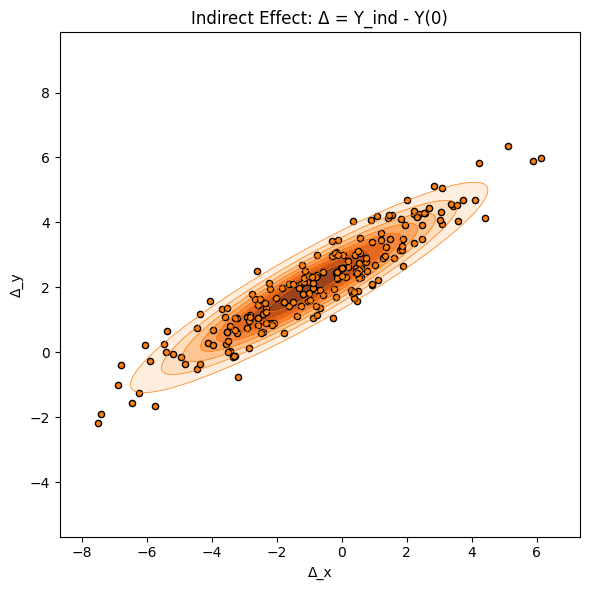

In [89]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

# Fix random seed for reproducibility
np.random.seed(0)

# Draw samples from P0
N = 200
X0 = np.random.multivariate_normal(m0, S0, size=N)

# Compute imputed Y(2) and effects Δ = Y(2) - X0
Y_dir = T(X0, A02, m0, m2)
Y_ind = T(T(X0, A01, m0, m1), A12, m1, m2)
Delta_dir = Y_dir - X0
Delta_ind = Y_ind - X0

# Prepare grid limits
x_min = min(Delta_dir[:,0].min(), Delta_ind[:,0].min()) - 1
x_max = max(Delta_dir[:,0].max(), Delta_ind[:,0].max()) + 1
y_min = min(Delta_dir[:,1].min(), Delta_ind[:,1].min()) - 1
y_max = max(Delta_dir[:,1].max(), Delta_ind[:,1].max()) + 1

x = np.linspace(x_min, x_max, 300)
y = np.linspace(y_min, y_max, 300)
X, Y = np.meshgrid(x, y)
pos = np.dstack([X, Y])

# Multivariate normal PDF function
def mvn_pdf(pos, mu, Sigma):
    det = np.linalg.det(Sigma)
    inv = np.linalg.inv(Sigma)
    norm = 1 / (2 * np.pi * np.sqrt(det))
    diff = pos - mu
    return norm * np.exp(-0.5 * np.einsum('...i,ij,...j', diff, inv, diff))

# Compute parameters for effect distributions
mu = m2 - m0
Sigma_dir = (A02 - np.eye(2)) @ S0 @ (A02 - np.eye(2)).T
Sigma_ind = (A12 @ A01 - np.eye(2)) @ S0 @ (A12 @ A01 - np.eye(2)).T

# Compute densities
Z_dir = mvn_pdf(pos, mu, Sigma_dir)
Z_ind = mvn_pdf(pos, mu, Sigma_ind)

# Define contour levels explicitly
levels_dir = np.linspace(Z_dir.min(), Z_dir.max(), 10)
levels_ind = np.linspace(Z_ind.min(), Z_ind.max(), 10)

# Plot for direct effects (blue)
plt.figure(figsize=(6,6))
plt.contourf(X, Y, Z_dir, levels=levels_dir[1:], extend='neither', alpha=0.9, cmap='Blues')
plt.contour(X, Y, Z_dir, levels=levels_dir, colors='C0', linewidths=0.5)
plt.scatter(Delta_dir[:,0], Delta_dir[:,1], s=20, color='C0', edgecolor='black')
plt.title('Direct Effect: Δ = Y_dir - Y(0)')
plt.xlabel('Δ_x')
plt.ylabel('Δ_y')
plt.axis('equal')

# Plot for indirect effects (orange)
plt.figure(figsize=(6,6))
plt.contourf(X, Y, Z_ind, levels=levels_ind[1:], extend='neither', alpha=0.9, cmap='Oranges')
plt.contour(X, Y, Z_ind, levels=levels_ind, colors='C1', linewidths=0.5)
plt.scatter(Delta_ind[:,0], Delta_ind[:,1], s=20, color='C1', edgecolor='black')
plt.title('Indirect Effect: Δ = Y_ind - Y(0)')
plt.xlabel('Δ_x')
plt.ylabel('Δ_y')
plt.axis('equal')

plt.tight_layout()
plt.show()


In [19]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

# Increase overall font sizes and line widths
plt.rcParams.update({
    'font.size': 36,
    'axes.titlesize': 32,
    'axes.labelsize': 32,
    'xtick.labelsize': 28,
    'ytick.labelsize': 28,
    'legend.fontsize': 18,
    'lines.linewidth': 2,
    'patch.linewidth': 2
})

# Fix random seed for reproducibility
np.random.seed(0)

# 1) Define three 2D Gaussians (means and covariances)
#m0 = np.array([0.0, 0.0])
#m1 = np.array([1.0, 1.0])
#m2 = np.array([-1.0, 2.0])
#S0 = np.array([[10.0, 0.0],
#               [0.0, 1.0]])
#S1 = np.array([[1.0, -0.9],
#               [-0.9, 1.0]])
#S2 = np.array([[0.5, 0.0],
#               [0.0, 5.0]])
m0 = np.array([0.0, 0.0])
m1 = np.array([1.0, 1.0])
m2 = np.array([2.0, 2.0])
S0 = np.array([[1.0, 0.0],
              [0.0, 1.0]])
S1 = np.array([[1.0, -0.9],
               [-0.9, 1.0]])
S2 = np.array([[1.0, 0.0],
               [0.0, 1.0]])

# Draw samples from P0
N = 200
X0 = np.random.multivariate_normal(m0, S0, size=N)

# Compute Brenier-map matrices
def compute_A(S, S_prime):
    sqrtS     = scipy.linalg.sqrtm(S)
    inv_sqrtS = scipy.linalg.inv(sqrtS)
    M         = sqrtS @ S_prime @ sqrtS
    A         = inv_sqrtS @ scipy.linalg.sqrtm(M) @ inv_sqrtS
    return A.real

A01 = compute_A(S0, S1)
A02 = compute_A(S0, S2)
A12 = compute_A(S1, S2)

# Affine Brenier transport
def T(x, A, m, m_prime):
    return (m_prime + (A @ (x - m).T).T)

# Transform and compute effects Δ = Y(2) - X0
X02_direct   = T(X0, A02, m0, m2)
X02_indirect = T(T(X0, A01, m0, m1), A12, m1, m2)
Delta_dir = X02_direct - X0
Delta_ind = X02_indirect - X0

# Prepare grid for contour shading
x_min = min(Delta_dir[:,0].min(), Delta_ind[:,0].min()) - 1
x_max = max(Delta_dir[:,0].max(), Delta_ind[:,0].max()) + 1
y_min = min(Delta_dir[:,1].min(), Delta_ind[:,1].min()) - 1
y_max = max(Delta_dir[:,1].max(), Delta_ind[:,1].max()) + 1

x = np.linspace(x_min, x_max, 300)
y = np.linspace(y_min, y_max, 300)
Xg, Yg = np.meshgrid(x, y)
pos = np.dstack([Xg, Yg])

# Multivariate normal PDF for Δ
def mvn_pdf(pos, mu, Sigma):
    det = np.linalg.det(Sigma)
    inv = np.linalg.inv(Sigma)
    norm = 1 / (2 * np.pi * np.sqrt(det))
    diff = pos - mu
    return norm * np.exp(-0.5 * np.einsum('...i,ij,...j', diff, inv, diff))

# Compute effect distribution parameters
mu = m2 - m0
Sigma_dir = (A02 - np.eye(2)) @ S0 @ (A02 - np.eye(2)).T
Sigma_ind = (A12 @ A01 - np.eye(2)) @ S0 @ (A12 @ A01 - np.eye(2)).T

# Compute densities and levels
Z_dir = mvn_pdf(pos, mu, Sigma_dir)
Z_ind = mvn_pdf(pos, mu, Sigma_ind)
levels_dir = np.linspace(Z_dir.min(), Z_dir.max(), 10)
levels_ind = np.linspace(Z_ind.min(), Z_ind.max(), 10)

# Create side-by-side subplots with larger figure size
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot 1: Direct vs Indirect Brenier transport
ax = axes[0]
ax.scatter(X02_direct[:,0], X02_direct[:,1], color='C0', label='Direct', s=80, edgecolor = "black")
ax.scatter(X02_indirect[:,0], X02_indirect[:,1], color='C1', label='Indirect', s=80, edgecolor = "black")
for i in range(N):
    ax.plot([X02_direct[i,0], X02_indirect[i,0]],
            [X02_direct[i,1], X02_indirect[i,1]],
            color='black', linestyle='--', linewidth=2)
ax.set_title(r'Direct vs Indirect OT Map')
ax.set_xlabel(r"$Y_2(2)$")
ax.set_ylabel(r"$Y_1(2)$")
ax.legend()
#ax.set_aspect('equal')

# Plot 2: Direct effect
ax = axes[1]
contf1 = ax.contourf(Xg, Yg, Z_dir, levels=levels_dir[1:], extend='neither',
                     alpha=0.9, cmap='Blues')
ax.contour(Xg, Yg, Z_dir, levels=levels_dir, colors='C0', linewidths=2)
ax.scatter(Delta_dir[:,0], Delta_dir[:,1], s=50, color='C0', edgecolor='black', zorder = 100)
ax.set_title('Total Effect (Direct OT)')
ax.set_xlabel(r'$Y_1(2) - Y_1(0)$'); ax.set_ylabel(r'$Y_2(2) - Y_2(0)$')
#ax.set_aspect('equal')

# Plot 3: Indirect effect
ax = axes[2]
contf2 = ax.contourf(Xg, Yg, Z_ind, levels=levels_ind[1:], extend='neither',
                     alpha=0.9, cmap='Oranges')
ax.contour(Xg, Yg, Z_ind, levels=levels_ind, colors='C1', linewidths=2)
ax.scatter(Delta_ind[:,0], Delta_ind[:,1], s=50, color='C1', edgecolor='black', zorder = 100)
ax.set_title('Total Effect (Indirect OT)')
ax.set_xlabel(r'$Y_1(2) - Y_1(0)$'); ax.set_ylabel(r'$Y_2(2) - Y_2(0)$')
#ax.set_aspect('equal')

plt.tight_layout()
plt.savefig("brenierinconsistencylim.png", bbox_inches = "tight")
plt.show()

LinAlgError: Singular matrix

In [5]:
A02

array([[1., 0.],
       [0., 1.]])

In [4]:
Sigma_dir

array([[0., 0.],
       [0., 0.]])

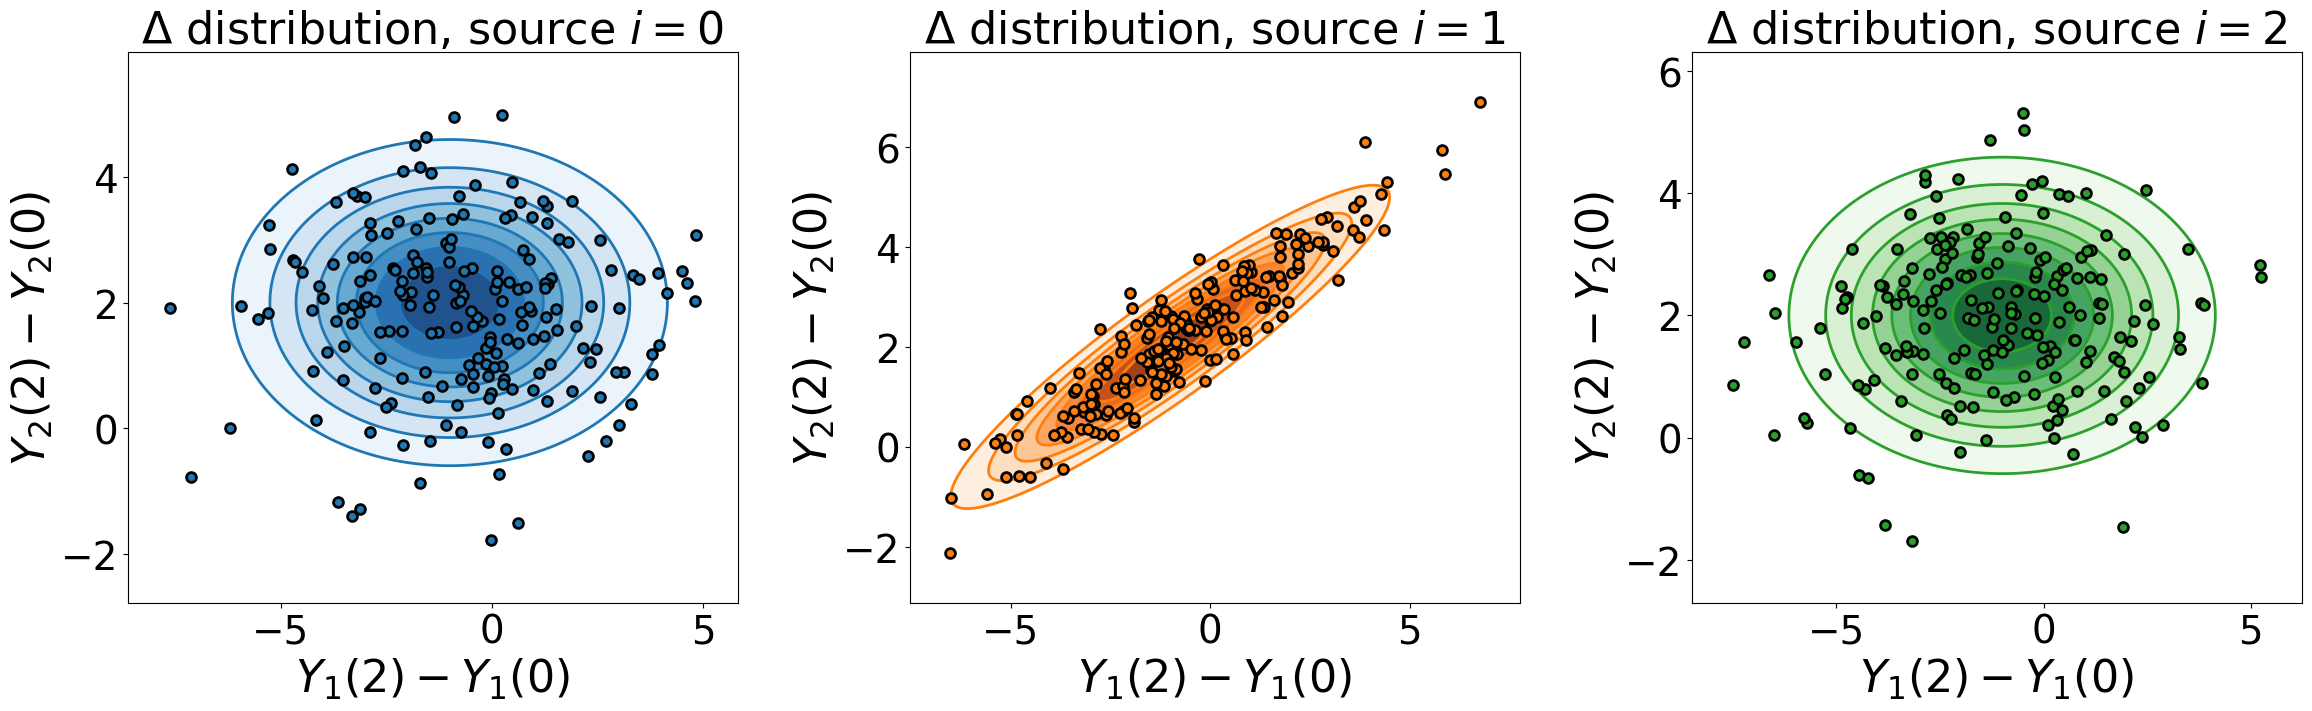

In [3]:
# ------------------------------------------------------------------
#  ADD-ON: effect distributions Δ = Y(2) – Y(0) for every source i
# ------------------------------------------------------------------
sources = {0: (m0, S0),
           1: (m1, S1),
           2: (m2, S2)}

fig, axes = plt.subplots(1, 3, figsize=(24, 8))
for idx, (i, (mi, Si)) in enumerate(sources.items()):
    # 1) sample X_i
    Xi = np.random.multivariate_normal(mi, Si, size=N)

    # 2) Brenier maps to 0 and 2
    Ai0 = compute_A(Si, S0)          # i → 0
    Ai2 = compute_A(Si, S2)          # i → 2
    Y0  = T(Xi, Ai0, mi, m0)         # Y(0)
    Y2  = T(Xi, Ai2, mi, m2)         # Y(2)

    # 3) total effect Δ = Y(2) – Y(0)
    Delta = Y2 - Y0
    Sigma = (Ai2 - Ai0) @ Si @ (Ai2 - Ai0).T
    mu    = m2 - m0                  # mean of Δ

    # grid & density for contours
    _min = Delta.min(axis=0) - 1
    _max = Delta.max(axis=0) + 1
    x = np.linspace(_min[0], _max[0], 300)
    y = np.linspace(_min[1], _max[1], 300)
    Xg, Yg = np.meshgrid(x, y)
    Z = mvn_pdf(np.dstack([Xg, Yg]), mu, Sigma)
    levels = np.linspace(Z.min(), Z.max(), 10)

    # plot
    ax = axes[idx]
    cmap = ['Blues', 'Oranges', 'Greens'][idx]
    colour = ['C0', 'C1', 'C2'][idx]
    ax.contourf(Xg, Yg, Z, levels=levels[1:], cmap=cmap, alpha=0.9)
    ax.contour(Xg, Yg, Z, levels=levels, colors=colour, linewidths=2)
    ax.scatter(Delta[:, 0], Delta[:, 1], s=50, color=colour,
               edgecolor='black', zorder=100)
    ax.set_title(rf'$\Delta$ distribution, source $i={i}$')
    ax.set_xlabel(r'$Y_1(2)-Y_1(0)$')
    ax.set_ylabel(r'$Y_2(2)-Y_2(0)$')

plt.tight_layout()
plt.savefig("effects_all_sources.png", bbox_inches="tight")
plt.show()
